# CNN1D parameter exploration
This notebook is used to find a new CNN1D model for data downsampled to 2000Hz. It is based on a template provided by the rippl_AI repository.

This architecture is based in the CNN1D designed by A. Navas-Olivé (https://doi.org/10.7554/eLife.77772).

In [13]:
import os
import importlib
import matplotlib.pyplot as plt
import numpy as np
import sys
import scipy
rippl_AI_repo = 'C:/Users/RECORDING/Athina/Github/rippl-AI'
sys.path.insert(1, rippl_AI_repo)
sys.path.insert(0,parent_dir)
import rippl_AI
import aux_fcn
importlib.reload(aux_fcn)
importlib.reload(rippl_AI)

from downsample_filter_LFP import import_lfp
from aux_fcn_nt import retrain_model_new, prepare_training_data_new 

ripple_analysis_dir = 'C:/Users/RECORDING/Athina/Ripples/'
parent_dir = os.path.join(ripple_analysis_dir, 'retraining')
animal = 'rEO_06'

### Data load
4 sessions will be loaded: sessions 1 and 2 will be used for training and sessions 3 and 4 for validation.

The data come from Eminhan Ozil's dataset, where probes have been implanted bilaterally. 

Theresfore each session will have data from the left and the right hemishpere so essentially the number of sessions used for training and validation will be 4. 

The training sessions' LFP will be appended together in a list. The same will happen with the ripples detection times.
That is the required input for the training parser

In [14]:
# =================================================
#                   TRAINING DATA
# =================================================
train_sessions = ['1_231218_153006', '2_240104_151545']
train_LFPs = []
train_SWRs = []
train_ch_map = []

# Load LFPs 
for session in train_sessions:
    lfp_file = os.path.join(ripple_analysis_dir, 'lfp_data', animal, session + '.amplifier_ds.lfp')

    lfp_data = import_lfp(raw_data_file=lfp_file, num_channels=16, channels=np.arange(0,16), sample_rate=2000, verbose=False)
    lfp = np.transpose(lfp_data)  # n_samples x n_channels
    
    train_LFPs.append(lfp[:,0:8])
    train_LFPs.append(lfp[:,8:16])
    
    train_ch_map.append([1,-1,-1,2,-1,-1,-1,4]) # left hemi 
    train_ch_map.append([0,-1,-1,3,-1,-1,-1,5]) # right hemi

# Load SWRs
for session in train_sessions:
    ripple_file = os.path.join(ripple_analysis_dir, 'curated_ripples', animal, session, 'curated_ripples.mat')

    ripple_data = scipy.io.loadmat(ripple_file)
    ripple_classes = [label[0] for label in ripple_data['ripple_classes'].flatten()]
    ripple_timestamps = ripple_data['ripple_timestamps']
            
    left_indices = [i for i, label in enumerate(ripple_classes) if 'left' in label]
    right_indices = [i for i, label in enumerate(ripple_classes) if 'right' in label]

    train_SWRs.append(ripple_timestamps[left_indices,:]) 
    train_SWRs.append(ripple_timestamps[right_indices,:])
    

# =================================================
#                  VALIDATION DATA
# =================================================
# 2 sessions will be used for VALIDATION. For each session, the left hemi SWRs are appended followed by the right hemi SWRs 
val_sessions = ['3_240112_150230', '4_240130_152039']
val_LFPs = []
val_SWRs = []
val_ch_map = []

# Load LFPs 
for session in val_sessions:
    lfp_file = os.path.join(ripple_analysis_dir, 'lfp_data', animal, session + '.amplifier_ds.lfp')

    lfp_data = import_lfp(raw_data_file=lfp_file, num_channels=16, channels=np.arange(0,16), sample_rate=2000, verbose=False)
    lfp = np.transpose(lfp_data)  # n_samples x n_channels
    
    val_LFPs.append(lfp[:,0:8])
    val_LFPs.append(lfp[:,8:16])
    
    val_ch_map.append([1,-1,-1,2,-1,-1,-1,4]) # left hemi 
    val_ch_map.append([0,-1,-1,3,-1,-1,-1,5]) # right hemi

# Load SWRs
for session in val_sessions:
    ripple_file = os.path.join(ripple_analysis_dir, 'curated_ripples', animal, session, 'curated_ripples.mat')

    ripple_data = scipy.io.loadmat(ripple_file)
    ripple_classes = [label[0] for label in ripple_data['ripple_classes'].flatten()]
    ripple_timestamps = ripple_data['ripple_timestamps']
            
    left_indices = [i for i, label in enumerate(ripple_classes) if 'left' in label]
    right_indices = [i for i, label in enumerate(ripple_classes) if 'right' in label]

    val_SWRs.append(ripple_timestamps[left_indices,:])
    val_SWRs.append(ripple_timestamps[right_indices,:])  
    

retrain_LFPs, retrain_SWRs, norm_val_LFP, val_SWRs = prepare_training_data_new(train_LFPs,train_SWRs,val_LFPs,val_SWRs,train_ch_map,val_ch_map,sf=2000,downsampled_fs=2000)


Original training data shape:  (1857639, 8)
Data is already sampled at 2000 Hz!
Normalizing data...
Shape of loaded data after downsampling and z-score:  (1857639, 8)
Original training data shape:  (1857639, 8)
Data is already sampled at 2000 Hz!
Normalizing data...
Shape of loaded data after downsampling and z-score:  (1857639, 8)
Original training data shape:  (1254503, 8)
Data is already sampled at 2000 Hz!
Normalizing data...
Shape of loaded data after downsampling and z-score:  (1254503, 8)
Original training data shape:  (1254503, 8)
Data is already sampled at 2000 Hz!
Normalizing data...
Shape of loaded data after downsampling and z-score:  (1254503, 8)
Original validation data shape:  (1987175, 8)
Data is already sampled at 2000 Hz!
Normalizing data...
Shape of loaded data after downsampling and z-score:  (1987175, 8)
Original validation data shape:  (1987175, 8)
Data is already sampled at 2000 Hz!
Normalizing data...
Shape of loaded data after downsampling and z-score:  (198717

## CNN1D training parameters

#### Parameters:
* Channels:  number of channels that will be used to train the model, extracted from the data shape defined in the previous cell
* Timesteps: number of samples that the model will use to produce a single output
* Configuration: list with as many elements as layers in the model shaped [number of kernels layers, kernel size and stride ]. The length size and the kernel layer were matched to reduce design complexity.
* Epoch: number of times the training data set is used to train the model
* Training batch: number of windows that are proccessed before weight updating

In [27]:
conf= {"timesteps":   [16],        # 16, 32, 64 ...
      "configuration":      [[[4,2],[2,1],[8,2],[4,1],[16,2],[8,1],[32,2]]],        # [[4,4],[2,1],[8,2],[4,1],[16,2],[8,1],[32,2]]]  
      "epochs":      [1, 2, 3, 4, 5],         # 1, 2, 3, 5...
      "train_batch": [2**5, 2**6],      # 32, 64, 128...
}

### Training

In [28]:
# Desired sampling frequency of the models
sf=2000
th_arr=np.linspace(0.1,0.9,9)
model_name_arr=[]           # To plot in the next cell
model_arr=[]                # Actual model array, used in the next validation section
n_channels=retrain_LFPs.shape[1]
timesteps_arr=conf['timesteps']

config_arr=conf['configuration']
epochs_arr=conf['epochs']
train_batch_arr=conf['train_batch']   

l_ts=len(timesteps_arr)
l_conf=len(config_arr)
l_epochs =len(epochs_arr)
l_batch =len(train_batch_arr)
n_iters=l_ts*l_conf*l_epochs*l_batch
# GT is in the shape (n_events x 2), a y output signal with the same length as x is required
perf_train_arr=np.zeros(shape=(n_iters,len(th_arr),3)) # Performance array, (n_models x n_th x 3 ) [P R F1]
perf_test_arr=np.zeros_like(perf_train_arr)
timesteps_arr_ploting=[]            # Array that will be used in the validation, to be able to call the function predict

print(f'{n_channels} channels will be used to train the CNN1D models')

print(f'{n_iters} models will be trained')

x_test_or,GT_test,x_train_or,GT_train=aux_fcn.split_data(retrain_LFPs,retrain_SWRs,split=0.7,sf=sf)

y_test_or= np.zeros(shape=(len(x_test_or)))
for ev in GT_test:
    y_test_or[int(sf*ev[0]):int(sf*ev[1])]=1
y_train_or= np.zeros(shape=(len(x_train_or)))
for ev in GT_train:
    y_train_or[int(sf*ev[0]):int(sf*ev[1])]=1


for i_ts,timesteps in enumerate(timesteps_arr):
    x_train=x_train_or[:len(x_train_or)-len(x_train_or)%timesteps].reshape(-1,timesteps,n_channels)
    y_train_aux=y_train_or[:len(y_train_or)-len(y_train_or)%timesteps].reshape(-1,timesteps)
    x_test=x_test_or[:len(x_test_or)-len(x_test_or)%timesteps].reshape(-1,timesteps,n_channels)
    y_test_aux=y_test_or[:len(y_test_or)-len(y_test_or)%timesteps].reshape(-1,timesteps)

    y_train=np.zeros(shape=[x_train.shape[0],1])
    for i in range(y_train_aux.shape[0]):
        y_train[i]=1  if any (y_train_aux[i]==1) else 0
    print("Train Input and Output dimension", x_train.shape,y_train.shape)
    
    y_test=np.zeros(shape=[x_test.shape[0],1])
    for i in range(y_test_aux.shape[0]):
        y_test[i]=1  if any (y_test_aux[i]==1) else 0

    for i_conf, configuration in enumerate(config_arr):
        for i_epochs,epochs in enumerate(epochs_arr):
            for i_batch,train_batch in enumerate(train_batch_arr):
                iter=((i_ts*l_conf+i_conf)*l_epochs + i_epochs)*l_batch + i_batch
                print(f"\nIteration {iter+1} out of {n_iters}")
                print(f'Number of channels: {n_channels:d}, Time steps: {timesteps:d},\nconfiguration: {configuration}\nEpochs: {epochs:d}, Samples per batch: {train_batch:d}')

                model = aux_fcn.build_CNN1D(n_channels,timesteps,configuration)
                # Training
                model.fit(x_train, y_train,shuffle=False, epochs=epochs,batch_size=train_batch,validation_data=(x_test,y_test), verbose=1)
                model_arr.append(model)
                # Prediction
                test_signal = model.predict(x_test,verbose=1)
                train_signal=model.predict(x_train,verbose=1)

                y_train_predict=np.empty(shape=(x_train.shape[0]*timesteps,1,1))
                for i,window in enumerate(train_signal):
                    y_train_predict[i*timesteps:(i+1)*timesteps]=window
                y_test_predict=np.empty(shape=(x_test.shape[0]*timesteps,1,1))
                for i,window in enumerate(test_signal):
                    y_test_predict[i*timesteps:(i+1)*timesteps]=window
                
                ############################
                for i,th in enumerate(th_arr):
                    # Test
                    ytest_pred_ind=aux_fcn.get_predictions_index(y_test_predict,th)/sf
                    perf_test_arr[iter,i]=aux_fcn.get_performance(ytest_pred_ind,GT_test,0)[0:3]
                    # Train
                    ytrain_pred_ind=aux_fcn.get_predictions_index(y_train_predict,th)/sf
                    perf_train_arr[iter,i]=aux_fcn.get_performance(ytrain_pred_ind,GT_train,0)[0:3]

                # Saving the model
                model_name=f"CNN1D_Ch{n_channels:d}_Ts{timesteps:03d}_C{i_conf:02d}_E{epochs:02d}_TB{train_batch:04d}"
                model.save(os.path.join(parent_dir,'explore_models_new_timesteps',model_name))

                model_name_arr.append(model_name)
                timesteps_arr_ploting.append(timesteps)

8 channels will be used to train the CNN1D models
10 models will be trained
Train Input and Output dimension (285000, 16, 8) (285000, 1)

Iteration 1 out of 10
Number of channels: 8, Time steps: 16,
configuration: [[4, 2], [2, 1], [8, 2], [4, 1], [16, 2], [8, 1], [32, 2]]
Epochs: 1, Samples per batch: 32
8907/8907 [==============================] - 12s 1ms/step
precision = 0.32494646680942185
recall = 0.9559633027522936
F1 = 0.4850254171066445
precision = 0.2938835358190197
recall = 0.9369085173501577
F1 = 0.4474224335603064
precision = 0.5120068610634648
recall = 0.9027522935779817
F1 = 0.6534191584995946
precision = 0.49736247174076864
recall = 0.8824921135646687
F1 = 0.6361807447950786
precision = 0.6141552511415526
recall = 0.8201834862385321
F1 = 0.7023724338548619
precision = 0.6038114343029087
recall = 0.8020504731861199
F1 = 0.688954219497717
precision = 0.691114245416079
recall = 0.7321100917431193
F1 = 0.7110217277853443
precision = 0.6930564568462038
recall = 0.6963722397476

INFO:tensorflow:Assets written to: C:/Users/RECORDING/Athina/Ripples/retraining\explore_models_new_timesteps\CNN1D_Ch8_Ts016_C00_E01_TB0032\assets



Iteration 2 out of 10
Number of channels: 8, Time steps: 16,
configuration: [[4, 2], [2, 1], [8, 2], [4, 1], [16, 2], [8, 1], [32, 2]]
Epochs: 1, Samples per batch: 64
8907/8907 [==============================] - 13s 1ms/step
precision = 0.3835051546391753
recall = 0.965137614678899
F1 = 0.5489003590664273
precision = 0.3449098621420997
recall = 0.9621451104100947
F1 = 0.5077878809400869
precision = 0.538160469667319
recall = 0.9192660550458716
F1 = 0.6788852042199041
precision = 0.5164300202839757
recall = 0.9156151419558359
F1 = 0.6603858017899348
precision = 0.6337349397590362
recall = 0.8752293577981651
F1 = 0.7351577837030091
precision = 0.6343283582089553
recall = 0.863564668769716
F1 = 0.7314054457585164
precision = 0.7220588235294118
recall = 0.8110091743119265
F1 = 0.7639534986051341
precision = 0.7051532941943901
recall = 0.7854889589905363
F1 = 0.7431563486169129
precision = 0.786096256684492
recall = 0.7357798165137615
F1 = 0.7601062526595401
precision = 0.7696584590945195

INFO:tensorflow:Assets written to: C:/Users/RECORDING/Athina/Ripples/retraining\explore_models_new_timesteps\CNN1D_Ch8_Ts016_C00_E01_TB0064\assets



Iteration 3 out of 10
Number of channels: 8, Time steps: 16,
configuration: [[4, 2], [2, 1], [8, 2], [4, 1], [16, 2], [8, 1], [32, 2]]
Epochs: 2, Samples per batch: 32
Epoch 1/2
8907/8907 [==============================] - 34s 4ms/step - loss: 0.0846 - mse: 0.0204 - val_loss: 0.0710 - val_mse: 0.0182
Epoch 2/2
8907/8907 [==============================] - 12s 1ms/step
precision = 0.3295838020247469
recall = 0.9779816513761468
F1 = 0.49301839557268734
precision = 0.2993182318011876
recall = 0.9763406940063092
F1 = 0.458173519979921
precision = 0.48806584362139915
recall = 0.9504587155963302
F1 = 0.6449475358378256
precision = 0.46927175843694496
recall = 0.9361198738170347
F1 = 0.6251561617587637
precision = 0.5871657754010695
recall = 0.8862385321100917
F1 = 0.7063491429256402
precision = 0.5783078307830783
recall = 0.8935331230283912
F1 = 0.7021644570675102
precision = 0.6478149100257069
recall = 0.8146788990825689
F1 = 0.7217276879015404
precision = 0.6555370061213133
recall = 0.8201

INFO:tensorflow:Assets written to: C:/Users/RECORDING/Athina/Ripples/retraining\explore_models_new_timesteps\CNN1D_Ch8_Ts016_C00_E02_TB0032\assets



Iteration 4 out of 10
Number of channels: 8, Time steps: 16,
configuration: [[4, 2], [2, 1], [8, 2], [4, 1], [16, 2], [8, 1], [32, 2]]
Epochs: 2, Samples per batch: 64
Epoch 1/2
4454/4454 [==============================] - 18s 4ms/step - loss: 0.0781 - mse: 0.0190 - val_loss: 0.0636 - val_mse: 0.0162
Epoch 2/2
8907/8907 [==============================] - 12s 1ms/step
precision = 0.25827505827505826
recall = 0.9798165137614678
F1 = 0.40879394207384484
precision = 0.23485521406999468
recall = 0.9794952681388013
F1 = 0.3788684967800455
precision = 0.4228187919463087
recall = 0.9504587155963302
F1 = 0.5852739940995544
precision = 0.3987008969996907
recall = 0.9329652996845426
F1 = 0.5586596742937606
precision = 0.5330776605944392
recall = 0.928440366972477
F1 = 0.6772832212697014
precision = 0.5206782464846981
recall = 0.8982649842271293
F1 = 0.6592329090309788
precision = 0.6158323632130385
recall = 0.891743119266055
F1 = 0.7285396703500672
precision = 0.6146881287726358
recall = 0.86593

INFO:tensorflow:Assets written to: C:/Users/RECORDING/Athina/Ripples/retraining\explore_models_new_timesteps\CNN1D_Ch8_Ts016_C00_E02_TB0064\assets



Iteration 5 out of 10
Number of channels: 8, Time steps: 16,
configuration: [[4, 2], [2, 1], [8, 2], [4, 1], [16, 2], [8, 1], [32, 2]]
Epochs: 3, Samples per batch: 32
Epoch 1/3
8907/8907 [==============================] - 34s 4ms/step - loss: 0.0745 - mse: 0.0178 - val_loss: 0.0676 - val_mse: 0.0178
Epoch 2/3
8907/8907 [==============================] - 32s 4ms/step - loss: 0.0552 - mse: 0.0134 - val_loss: 0.0726 - val_mse: 0.0198
Epoch 3/3
8907/8907 [==============================] - 12s 1ms/step
precision = 0.5481832543443917
recall = 0.9467889908256881
F1 = 0.6943458272821927
precision = 0.5191475191475191
recall = 0.9345425867507886
F1 = 0.6674950369144448
precision = 0.7375178316690443
recall = 0.7541284403669725
F1 = 0.7457306501765297
precision = 0.7039904705181655
recall = 0.7476340694006309
F1 = 0.7251561899362814
precision = 0.8231884057971014
recall = 0.4568807339449541
F1 = 0.5876228265159856
precision = 0.8376383763837638
recall = 0.4676656151419558
F1 = 0.60021982480899

INFO:tensorflow:Assets written to: C:/Users/RECORDING/Athina/Ripples/retraining\explore_models_new_timesteps\CNN1D_Ch8_Ts016_C00_E03_TB0032\assets



Iteration 6 out of 10
Number of channels: 8, Time steps: 16,
configuration: [[4, 2], [2, 1], [8, 2], [4, 1], [16, 2], [8, 1], [32, 2]]
Epochs: 3, Samples per batch: 64
Epoch 1/3
4454/4454 [==============================] - 18s 4ms/step - loss: 0.0802 - mse: 0.0194 - val_loss: 0.0691 - val_mse: 0.0175
Epoch 2/3
4454/4454 [==============================] - 16s 4ms/step - loss: 0.0602 - mse: 0.0144 - val_loss: 0.0657 - val_mse: 0.0166
Epoch 3/3
8907/8907 [==============================] - 12s 1ms/step
precision = 0.41625089094796863
recall = 0.9798165137614678
F1 = 0.5842833883850032
precision = 0.37054179145112986
recall = 0.9810725552050473
F1 = 0.5379173179813692
precision = 0.5725725725725725
recall = 0.9486238532110092
F1 = 0.7141168501719947
precision = 0.5507910074937552
recall = 0.944794952681388
F1 = 0.6958938873716841
precision = 0.6654456654456654
recall = 0.8972477064220183
F1 = 0.7641545140183165
precision = 0.6468477703741671
recall = 0.8943217665615142
F1 = 0.7507156439746

INFO:tensorflow:Assets written to: C:/Users/RECORDING/Athina/Ripples/retraining\explore_models_new_timesteps\CNN1D_Ch8_Ts016_C00_E03_TB0064\assets



Iteration 7 out of 10
Number of channels: 8, Time steps: 16,
configuration: [[4, 2], [2, 1], [8, 2], [4, 1], [16, 2], [8, 1], [32, 2]]
Epochs: 4, Samples per batch: 32
Epoch 1/4
8907/8907 [==============================] - 33s 4ms/step - loss: 0.0774 - mse: 0.0182 - val_loss: 0.0668 - val_mse: 0.0170
Epoch 2/4
8907/8907 [==============================] - 32s 4ms/step - loss: 0.0592 - mse: 0.0141 - val_loss: 0.0693 - val_mse: 0.0178
Epoch 3/4
8907/8907 [==============================] - 31s 3ms/step - loss: 0.0528 - mse: 0.0128 - val_loss: 0.0695 - val_mse: 0.0187
Epoch 4/4
8907/8907 [==============================] - 12s 1ms/step
precision = 0.6694560669456067
recall = 0.7614678899082569
F1 = 0.7125036886015504
precision = 0.6246351430239346
recall = 0.7452681388012619
F1 = 0.6796402003666556
precision = 0.83
recall = 0.5559633027522936
F1 = 0.6658899847752697
precision = 0.7926565874730022
recall = 0.5157728706624606
F1 = 0.6249183110766274
precision = 0.9037037037037037
recall = 0.4

INFO:tensorflow:Assets written to: C:/Users/RECORDING/Athina/Ripples/retraining\explore_models_new_timesteps\CNN1D_Ch8_Ts016_C00_E04_TB0032\assets



Iteration 8 out of 10
Number of channels: 8, Time steps: 16,
configuration: [[4, 2], [2, 1], [8, 2], [4, 1], [16, 2], [8, 1], [32, 2]]
Epochs: 4, Samples per batch: 64
Epoch 1/4
4454/4454 [==============================] - 19s 4ms/step - loss: 0.0762 - mse: 0.0185 - val_loss: 0.0693 - val_mse: 0.0178
Epoch 2/4
4454/4454 [==============================] - 16s 4ms/step - loss: 0.0520 - mse: 0.0129 - val_loss: 0.0722 - val_mse: 0.0192
Epoch 3/4
4454/4454 [==============================] - 16s 4ms/step - loss: 0.0481 - mse: 0.0121 - val_loss: 0.0692 - val_mse: 0.0187
Epoch 4/4
8907/8907 [==============================] - 12s 1ms/step
precision = 0.45564821834723274
recall = 0.9688073394495413
F1 = 0.6197951711806027
precision = 0.44375194764724213
recall = 0.9684542586750788
F1 = 0.6086270709905741
precision = 0.7009803921568627
recall = 0.8752293577981651
F1 = 0.7784733199043613
precision = 0.6682564917859035
recall = 0.8588328075709779
F1 = 0.7516529639225691
precision = 0.8020134228187

INFO:tensorflow:Assets written to: C:/Users/RECORDING/Athina/Ripples/retraining\explore_models_new_timesteps\CNN1D_Ch8_Ts016_C00_E04_TB0064\assets



Iteration 9 out of 10
Number of channels: 8, Time steps: 16,
configuration: [[4, 2], [2, 1], [8, 2], [4, 1], [16, 2], [8, 1], [32, 2]]
Epochs: 5, Samples per batch: 32
Epoch 1/5
8907/8907 [==============================] - 33s 4ms/step - loss: 0.0777 - mse: 0.0185 - val_loss: 0.0717 - val_mse: 0.0183
Epoch 2/5
8907/8907 [==============================] - 32s 4ms/step - loss: 0.0579 - mse: 0.0142 - val_loss: 0.0955 - val_mse: 0.0239
Epoch 3/5
8907/8907 [==============================] - 32s 4ms/step - loss: 0.0524 - mse: 0.0131 - val_loss: 0.0944 - val_mse: 0.0246
Epoch 4/5
8907/8907 [==============================] - 32s 4ms/step - loss: 0.0489 - mse: 0.0125 - val_loss: 0.0923 - val_mse: 0.0245
Epoch 5/5
8907/8907 [==============================] - 12s 1ms/step
precision = 0.5075187969924813
recall = 0.7669724770642201
F1 = 0.6108365852470462
precision = 0.49627304825421736
recall = 0.7815457413249212
F1 = 0.607065869684333
precision = 0.7044025157232704
recall = 0.1944954128440367
F1

c:\Users\RECORDING\.conda\envs\Rippl_AI\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\RECORDING\.conda\envs\Rippl_AI\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


x is empty. Cant perform IoU
precision = nan
recall = 0.0
F1 = nan
x is empty. Cant perform IoU
precision = nan
recall = 0.0
F1 = nan
x is empty. Cant perform IoU
precision = nan
recall = 0.0
F1 = nan
x is empty. Cant perform IoU
precision = nan
recall = 0.0
F1 = nan
x is empty. Cant perform IoU
precision = nan
recall = 0.0
F1 = nan
x is empty. Cant perform IoU
precision = nan
recall = 0.0
F1 = nan
x is empty. Cant perform IoU
precision = nan
recall = 0.0
F1 = nan
x is empty. Cant perform IoU
precision = nan
recall = 0.0
F1 = nan
x is empty. Cant perform IoU
precision = nan
recall = 0.0
F1 = nan
x is empty. Cant perform IoU
precision = nan
recall = 0.0
F1 = nan
x is empty. Cant perform IoU
precision = nan
recall = 0.0
F1 = nan
INFO:tensorflow:Assets written to: C:/Users/RECORDING/Athina/Ripples/retraining\explore_models_new_timesteps\CNN1D_Ch8_Ts016_C00_E05_TB0032\assets


INFO:tensorflow:Assets written to: C:/Users/RECORDING/Athina/Ripples/retraining\explore_models_new_timesteps\CNN1D_Ch8_Ts016_C00_E05_TB0032\assets



Iteration 10 out of 10
Number of channels: 8, Time steps: 16,
configuration: [[4, 2], [2, 1], [8, 2], [4, 1], [16, 2], [8, 1], [32, 2]]
Epochs: 5, Samples per batch: 64
Epoch 1/5
4454/4454 [==============================] - 19s 4ms/step - loss: 0.0820 - mse: 0.0202 - val_loss: 0.0716 - val_mse: 0.0179
Epoch 2/5
4454/4454 [==============================] - 16s 4ms/step - loss: 0.0585 - mse: 0.0143 - val_loss: 0.0684 - val_mse: 0.0177
Epoch 3/5
4454/4454 [==============================] - 16s 4ms/step - loss: 0.0550 - mse: 0.0135 - val_loss: 0.0674 - val_mse: 0.0170
Epoch 4/5
4454/4454 [==============================] - 16s 4ms/step - loss: 0.0524 - mse: 0.0131 - val_loss: 0.0665 - val_mse: 0.0172
Epoch 5/5
8907/8907 [==============================] - 12s 1ms/step
precision = 0.4754816112084063
recall = 0.9064220183486238
F1 = 0.6237584047121033
precision = 0.4332040888262249
recall = 0.887223974763407
F1 = 0.5821582624157446
precision = 0.6078184110970997
recall = 0.8146788990825689
F1

INFO:tensorflow:Assets written to: C:/Users/RECORDING/Athina/Ripples/retraining\explore_models_new_timesteps\CNN1D_Ch8_Ts016_C00_E05_TB0064\assets


### Plot training results

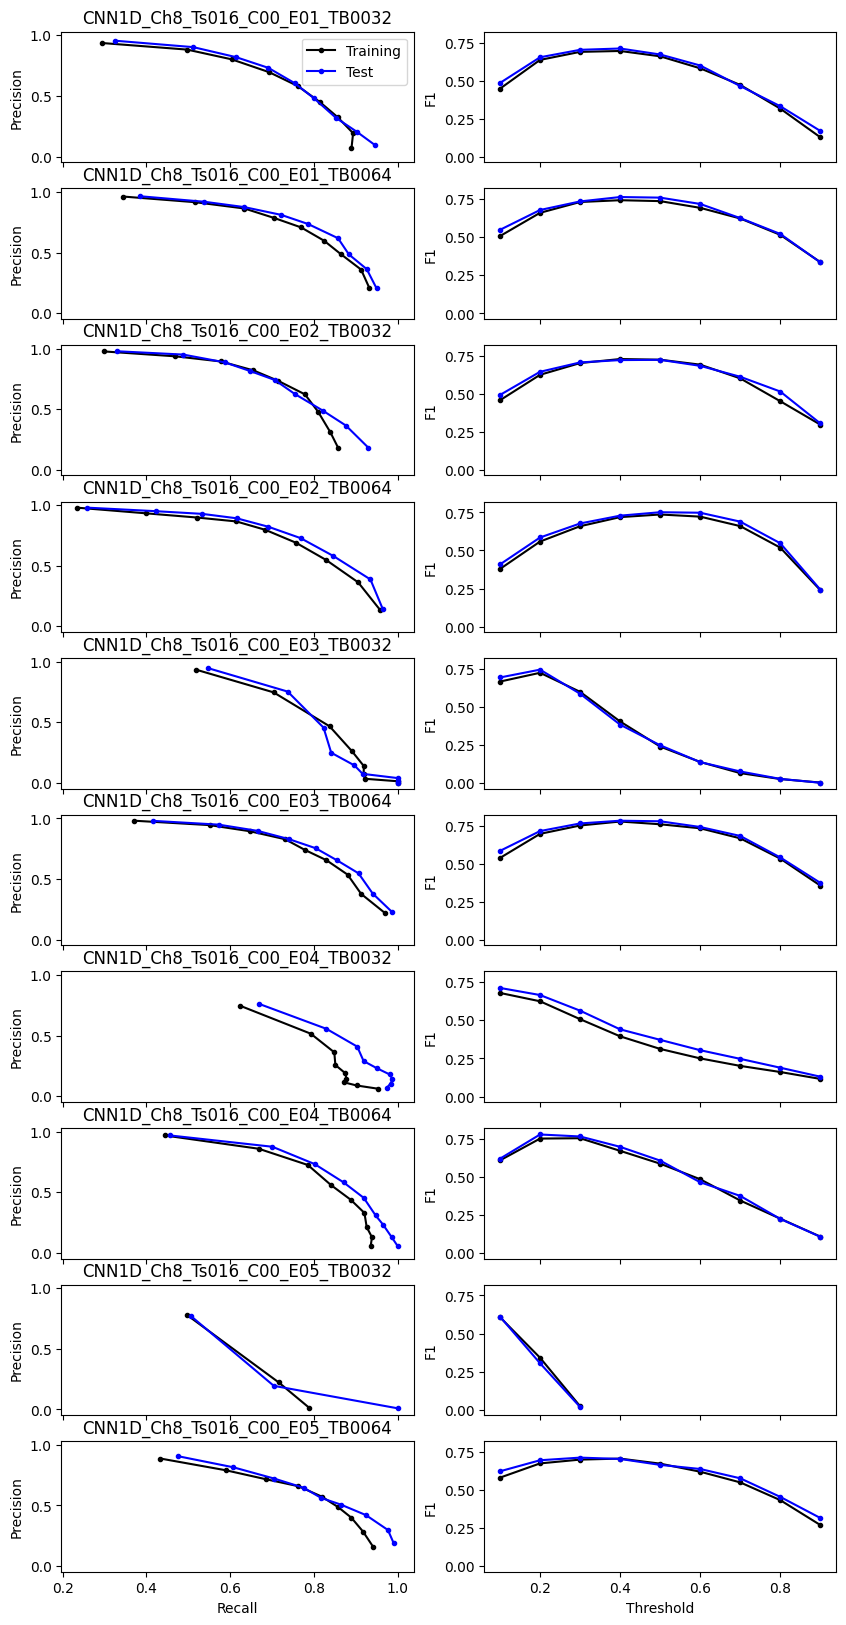

In [29]:
# Plot training results
fig,axs=plt.subplots(n_iters,2,figsize=(10,2*n_iters),sharey='col',sharex='col')

for i in range(n_iters):
    axs[i,0].plot(perf_train_arr[i,:,0],perf_train_arr[i,:,1],'k.-')
    axs[i,0].plot(perf_test_arr[i,:,0],perf_test_arr[i,:,1],'b.-')
    axs[i,1].plot(th_arr,perf_train_arr[i,:,2],'k.-')
    axs[i,1].plot(th_arr,perf_test_arr[i,:,2],'b.-')
    axs[i,0].set_title(model_name_arr[i])
    axs[i,0].set_ylabel('Precision')
    axs[i,1].set_ylabel('F1')
axs[-1,0].set_xlabel('Recall')
axs[-1,1].set_xlabel('Threshold')
axs[0,0].legend(['Training','Test'])
plt.show()
fig.savefig(os.path.join(parent_dir,'explore_models', 'new_CNN1D_train_test_performance.png'))


### Validation

3882/3882 [==============================] - 5s 1ms/step


C:\Users/RECORDING/Athina/Github/rippl-AI\aux_fcn.py:626: RuntimeWarning: invalid value encountered in scalar divide
  F1 = 2. * (precision * recall) / (precision + recall)


3882/3882 [==============================] - 6s 1ms/step
x is empty. Cant perform IoU
x is empty. Cant perform IoU
x is empty. Cant perform IoU
x is empty. Cant perform IoU
x is empty. Cant perform IoU
x is empty. Cant perform IoU


c:\Users\RECORDING\.conda\envs\Rippl_AI\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\RECORDING\.conda\envs\Rippl_AI\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


3882/3882 [==============================] - 5s 1ms/step
x is empty. Cant perform IoU
x is empty. Cant perform IoU
x is empty. Cant perform IoU
x is empty. Cant perform IoU
x is empty. Cant perform IoU
x is empty. Cant perform IoU
5042/5042 [==============================] - 7s 1ms/step
x is empty. Cant perform IoU
x is empty. Cant perform IoU
x is empty. Cant perform IoU
x is empty. Cant perform IoU
x is empty. Cant perform IoU
x is empty. Cant perform IoU
5042/5042 [==============================] - 7s 1ms/step
x is empty. Cant perform IoU
x is empty. Cant perform IoU
x is empty. Cant perform IoU
x is empty. Cant perform IoU
x is empty. Cant perform IoU
x is empty. Cant perform IoU
x is empty. Cant perform IoU
5042/5042 [==============================] - 7s 1ms/step


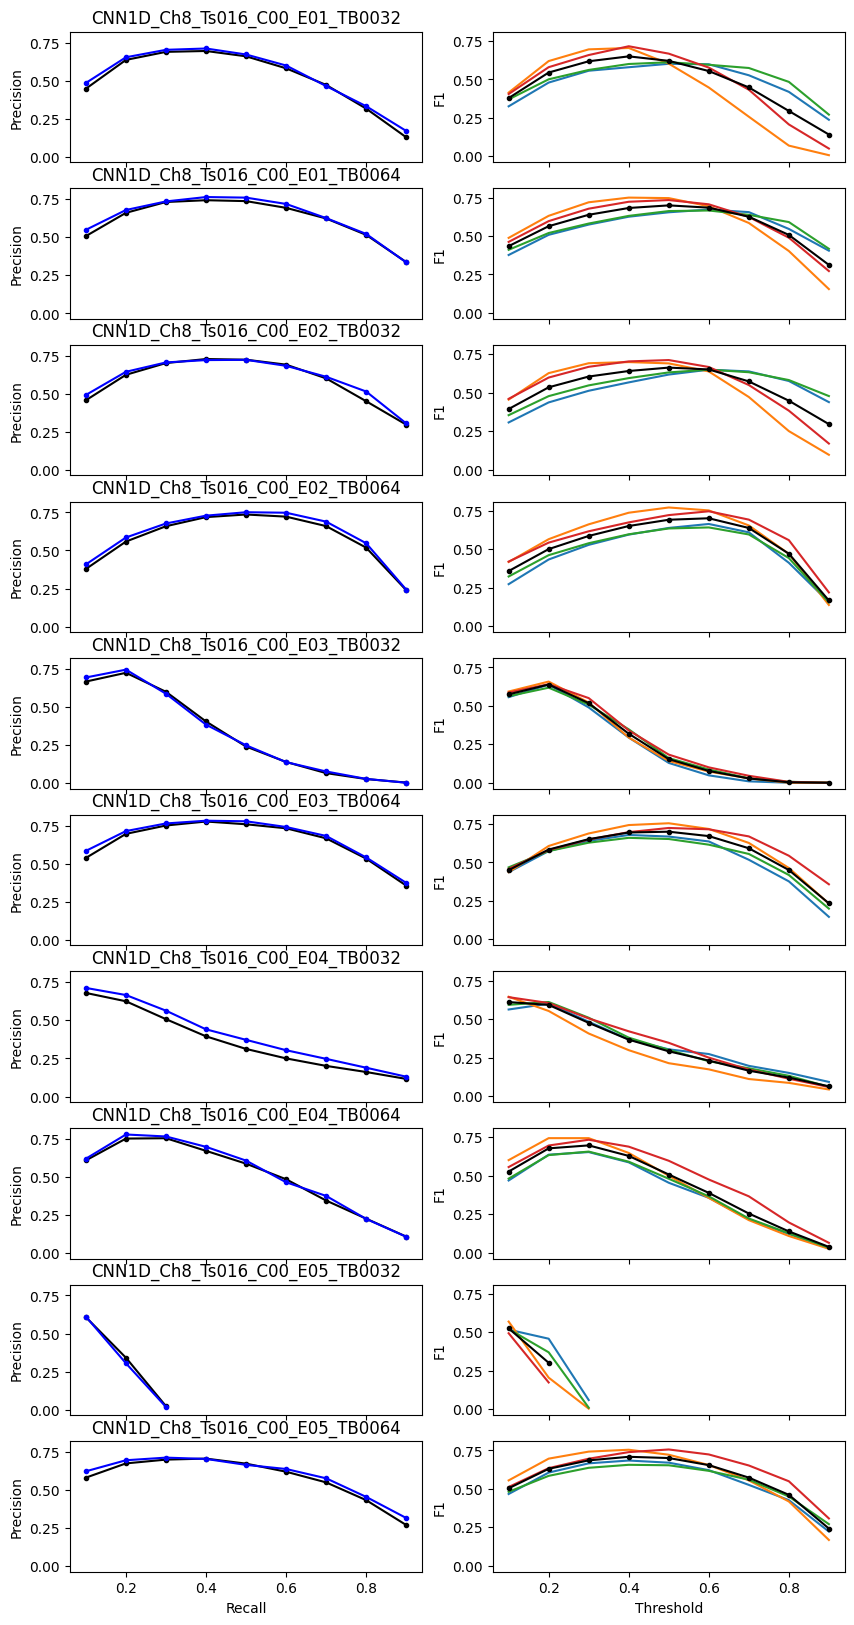

3882/3882 [==============================] - 5s 1ms/step
x is empty. Cant perform IoU
x is empty. Cant perform IoU
x is empty. Cant perform IoU
x is empty. Cant perform IoU
x is empty. Cant perform IoU
x is empty. Cant perform IoU
3882/3882 [==============================] - 5s 1ms/step
x is empty. Cant perform IoU
x is empty. Cant perform IoU
x is empty. Cant perform IoU
x is empty. Cant perform IoU
x is empty. Cant perform IoU
x is empty. Cant perform IoU
5042/5042 [==============================] - 7s 1ms/step
x is empty. Cant perform IoU
x is empty. Cant perform IoU
x is empty. Cant perform IoU
x is empty. Cant perform IoU
x is empty. Cant perform IoU
x is empty. Cant perform IoU
5042/5042 [==============================] - 7s 1ms/step
x is empty. Cant perform IoU
x is empty. Cant perform IoU
x is empty. Cant perform IoU
x is empty. Cant perform IoU
x is empty. Cant perform IoU
x is empty. Cant perform IoU
x is empty. Cant perform IoU
5042/5042 [==============================] - 6s

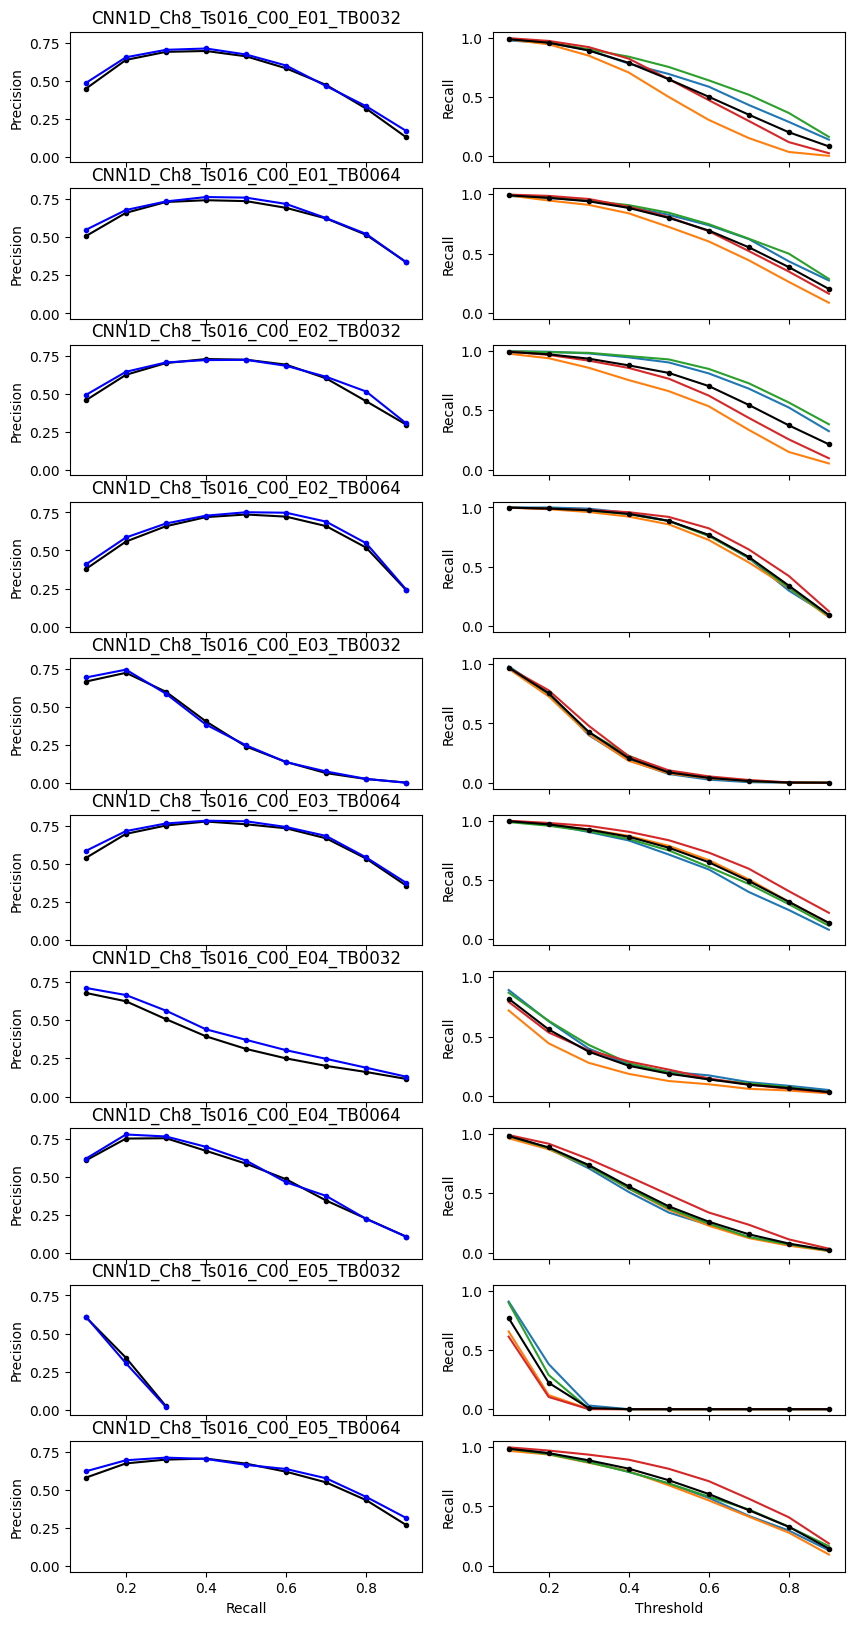

In [30]:
# For loop iterating over the models
fig,axs=plt.subplots(n_iters,2,figsize=(10,2*n_iters),sharey='col',sharex='col')
for n_m,model in enumerate(model_arr):
    F1_arr=np.zeros(shape=(len(norm_val_LFP),len(th_arr))) #(n_val_sess x n_th) Array where the F1 val of each sesion will be stored
    for n_sess,LFP in enumerate(norm_val_LFP):
        val_pred = aux_fcn.prediction_parser(LFP,arch='CNN1D',new_model=model,n_channels=n_channels,n_timesteps=timesteps)
        # val_pred=rippl_AI.predict(LFP,sf=2000,arch='CNN1D',new_model=model,n_channels=n_channels,n_timesteps=timesteps_arr_ploting[n_m])[0]
        for i,th in enumerate(th_arr):
            val_pred_ind=aux_fcn.get_predictions_index(val_pred,th)/sf
            F1_arr[n_sess,i]=aux_fcn.get_performance(val_pred_ind,val_SWRs[n_sess],verbose=False)[2]
    
    axs[n_m,0].plot(th_arr,perf_train_arr[n_m,:,2],'k.-')
    axs[n_m,0].plot(th_arr,perf_test_arr[n_m,:,2],'b.-')
    for F1 in F1_arr:
        axs[n_m,1].plot(th_arr,F1)
    axs[n_m,1].plot(th_arr,np.mean(F1_arr,axis=0),'k.-')
    axs[n_m,0].set_title(model_name_arr[n_m])
    axs[n_m,0].set_ylabel('Precision')
    axs[n_m,1].set_ylabel('F1')
axs[-1,0].set_xlabel('Recall')
axs[-1,1].set_xlabel('Threshold')
plt.show()
fig.savefig(os.path.join(parent_dir,'explore_models', 'new_CNN1D_validation_performance.png'))



fig,axs=plt.subplots(n_iters,2,figsize=(10,2*n_iters),sharey='col',sharex='col')
for n_m,model in enumerate(model_arr):
    recall_arr=np.zeros(shape=(len(norm_val_LFP),len(th_arr))) #(n_val_sess x n_th) Array where the F1 val of each sesion will be stored
    for n_sess,LFP in enumerate(norm_val_LFP):
        val_pred = aux_fcn.prediction_parser(LFP,arch='CNN1D',new_model=model,n_channels=n_channels,n_timesteps=timesteps)
        # val_pred=rippl_AI.predict(LFP,sf=2000,arch='CNN1D',new_model=model,n_channels=n_channels,n_timesteps=timesteps_arr_ploting[n_m])[0]
        for i,th in enumerate(th_arr):
            val_pred_ind=aux_fcn.get_predictions_index(val_pred,th)/sf
            recall_arr[n_sess,i]=aux_fcn.get_performance(val_pred_ind,val_SWRs[n_sess],verbose=False)[1]
    
    axs[n_m,0].plot(th_arr,perf_train_arr[n_m,:,2],'k.-')
    axs[n_m,0].plot(th_arr,perf_test_arr[n_m,:,2],'b.-')
    for r in recall_arr:
        axs[n_m,1].plot(th_arr,r)
    axs[n_m,1].plot(th_arr,np.mean(recall_arr,axis=0),'k.-')
    axs[n_m,0].set_title(model_name_arr[n_m])
    axs[n_m,0].set_ylabel('Precision')
    axs[n_m,1].set_ylabel('Recall')
axs[-1,0].set_xlabel('Recall')
axs[-1,1].set_xlabel('Threshold')
plt.show()
fig.savefig(os.path.join(parent_dir,'explore_models', 'new_CNN1D_validation_recall_performance.png'))

    